<a href="https://colab.research.google.com/github/ARYAMAN-SINHA/SLPA_Prediction_LSTM/blob/main/BTP_Paper_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Use this only if your data is stored in your google drive. Else just access it from your computer location.

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt
!pip install netCDF4          
from netCDF4 import Dataset
import numpy as np
import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
# from keras.layers.normalization import BatchNorm1alization
from keras.layers import Conv2D, Conv3D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D, MaxPooling3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten, LSTM
from keras.layers import Input, BatchNormalization, SimpleRNN
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.initializers import Initializer, RandomNormal
from keras import backend as K

In [ ]:
nc_file = 'drive/My Drive/slp_daily_anomalies_ncep_19900101_20191231.nc'  #Replace the link with your own data location
fh = Dataset(nc_file, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
length = fh.variables['time'][:]
length_units = fh.variables['time'].units
slpa = fh.variables['slpa'][:]
fh.close()

lat = len(lats)
lon = len(lons)
#print(lats, lons)
l = len(length)
#data = [[[0 for _ in range(32, 39)] for _ in range(41, 46)] for _ in range(0, l)] # the second box
#70-80,20-30
data = [[[0 for _ in range(28, 33)] for _ in range(44, 49)] for _ in range(0, l)] # the first box
#data = [[[0 for _ in range(34, 39)] for _ in range(41, 46)] for _ in range(0, l)] # updated second box
for i in range(0, l):
  item = slpa[i]
  for j in range(44, 49):
      for k in range(28, 33):
          data[i][j-44][k-28] = item[j][k]

#import pandas as pd
#data = pd.DataFrame(data)
#data.drop([10956], inplace=True)
data = np.array(data)
print(data.shape)
gap = 6     # for <Gap> days ahead prediction

[-90.  -87.5 -85.  -82.5 -80.  -77.5 -75.  -72.5 -70.  -67.5 -65.  -62.5
 -60.  -57.5 -55.  -52.5 -50.  -47.5 -45.  -42.5 -40.  -37.5 -35.  -32.5
 -30.  -27.5 -25.  -22.5 -20.  -17.5 -15.  -12.5 -10.   -7.5  -5.   -2.5
   0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90. ] [  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5 125.  127.5 130.  132.5 135.  137.5 140.  142.5 145.  147.5
 150.  152.5 155.  157.5 160.  162.5 165.  167.5 170.  172.5 175.  177.5
 180.  182.5 185.  187.5 190.  192.5 195.  197.5 200.  202.5 205.  207.5
 210.  212.5 215.  217.5 220.  222.5 225.  

In [ ]:
def average(y):
  a = []
  for i in y:
    i = i.reshape(25,1)     # used 25 here because we have 5x5, for a 5x10 it will be 50 and so on
    #print(i)
    a.append(sum(i)/25)
  return np.asarray(a)
  
X = data[:] 
#print(data[8917:9039])
y = average(data[gap:]) #deleted first <gap> values
y_train = y[:int(0.7*y.shape[0]):]
y_test = y[int(0.7*y.shape[0]):]
#np.savetxt("drive/My Drive/Box1_avg_observed.csv", y_test[888:], delimiter=",")
print(X.shape, y.shape, y_train.shape, y_test.shape)
#print(y_test[1253:1375])

In [ ]:
#This function prepares the 3D stack
def data_stack(X, days):
    stack = np.zeros([X.shape[0]-gap, days , X.shape[1], X.shape[2]])
    for i in range(X.shape[0]-gap):
        for j in range(days):
            stack[i, j , :,:] = X[i+j, :, :]
    return stack

f = data_stack(X,gap)
try3 = f.transpose(0,2,3,1)
try3 = try3.reshape(try3.shape[0],1,5,5,gap)
print(try3.shape)
train_set = try3[:int(0.7*try3.shape[0]):]
test_set = try3[int(0.7*try3.shape[0]):]
print(train_set.shape, test_set.shape)
#imgplot = plt.imshow(try3[1,0,:,:,1])
#plt.figure()

(10955, 1, 5, 5, 2)
(7668, 1, 5, 5, 2) (3287, 1, 5, 5, 2)


In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters= 10, kernel_size=(3,3),recurrent_initializer='random_uniform',
                   input_shape=(1, 5, 5, gap), padding = 'same' , return_sequences=True))
model.add(keras.layers.Activation(activation="relu"))
# model.add(Dropout(0.2))

#model.add(Conv3D(filters= 5, activation = "relu", kernel_size = (3, 3, 1),  strides= 1,data_format = "channels_first",
#         kernel_initializer = "random_uniform" ,use_bias = True))
#model.add(BatchNormalization())
#model.add(Dropout(0.1))

model.add(Conv3D(filters= 5, activation = "relu", kernel_size = (3, 3, 1),  strides= 1,data_format = "channels_first",
         kernel_initializer = "random_uniform" ,use_bias = True, padding='same'))
model.add(BatchNormalization())
#model.add(Dropout(0.1))

model.add(Conv3D(filters= 5, activation = "relu", kernel_size = (3, 3, 1), strides= 1,
               kernel_initializer = "random_uniform", data_format = "channels_first", use_bias = True, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling3D(pool_size=(3, 3, 1), data_format="channels_first"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(10, activation ='relu',use_bias = True))
model.add(Dense(1, activation ='linear', use_bias = True))

model.compile(loss='mse', optimizer='rmsprop', metrics=["mse","mape"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 5, 5, 10)       4360      
_________________________________________________________________
activation_3 (Activation)    (None, 1, 5, 5, 10)       0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 5, 5, 10)       50        
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 5, 5, 10)       40        
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 5, 5, 5, 10)       230       
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 5, 5, 10)       40        
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 5, 10)      

In [ ]:
R2_values = []
from sklearn.metrics import mean_squared_error, r2_score
history = model.fit(train_set, y_train, epochs=200, validation_split=0.66, batch_size=160, verbose=1)
print(history.history['val_loss'])
predicted_slpa = model.predict(test_set)
#print(predicted_slpa.shape)
r2 = r2_score(y_test, predicted_slpa)
R2_values.append(r2)

print(R2_values)

Epoch 1/200
17/17 [==============================] - 0s 24ms/step - loss: 10259.9697 - mse: 10259.9697 - mape: 191.4999 - val_loss: 13043.3291 - val_mse: 13043.3291 - val_mape: 325.0231
Epoch 2/200
17/17 [==============================] - 0s 21ms/step - loss: 10422.7715 - mse: 10422.7715 - mape: 199.9710 - val_loss: 12520.1924 - val_mse: 12520.1924 - val_mape: 286.9062
Epoch 3/200
17/17 [==============================] - 0s 17ms/step - loss: 10147.2754 - mse: 10147.2754 - mape: 196.4896 - val_loss: 12604.2236 - val_mse: 12604.2236 - val_mape: 283.2502
Epoch 4/200
17/17 [==============================] - 0s 18ms/step - loss: 10069.5645 - mse: 10069.5645 - mape: 184.3058 - val_loss: 12665.4404 - val_mse: 12665.4404 - val_mape: 293.6945
Epoch 5/200
17/17 [==============================] - 0s 18ms/step - loss: 9844.7734 - mse: 9844.7734 - mape: 203.4564 - val_loss: 13110.3672 - val_mse: 13110.3672 - val_mape: 302.7193
Epoch 6/200
17/17 [==============================] - 0s 18ms/step - loss

In [ ]:
#print(predicted_slpa[888:])
#np.savetxt("drive/My Drive/Box3_avg_predicted.csv", predicted_slpa[888:], delimiter=",")

In [ ]:
print(r2_score(y_test[3080:3202], predicted_slpa[3080:3202]), mean_squared_error(y_test[3080:3202], predicted_slpa[3080:3202]))  #2019
print(r2_score(y_test[2714:2836], predicted_slpa[2714:2836]), mean_squared_error(y_test[2714:2836], predicted_slpa[2714:2836]))  #2018
print(r2_score(y_test[2349:2471], predicted_slpa[2349:2471]), mean_squared_error(y_test[2349:2471], predicted_slpa[2349:2471]))  #2017
print(r2_score(y_test[1986:2106], predicted_slpa[1986:2106]), mean_squared_error(y_test[1986:2106], predicted_slpa[1986:2106]))  #2016
print(r2_score(y_test[1618:1740], predicted_slpa[1618:1740]), mean_squared_error(y_test[1618:1740], predicted_slpa[1618:1740]))  #2015
print(r2_score(y_test[1253:1375], predicted_slpa[1253:1375]), mean_squared_error(y_test[1253:1375], predicted_slpa[1253:1375]))  #2014
print(r2_score(y_test[888:1010], predicted_slpa[888:1010]), mean_squared_error(y_test[888:1010], predicted_slpa[888:1010]))  #2013
#print(np.corrcoef(y_test[3080:3202].notnull(), predicted_slpa[3080:3202].notnull()))

0.7235043081348332 10539.62
0.634155108191731 9274.62
0.6623890006221558 9450.324
0.6763249728504506 8778.478
0.6236718950008868 15289.24
0.74616395777814 10311.951
0.6047404771318585 13774.649


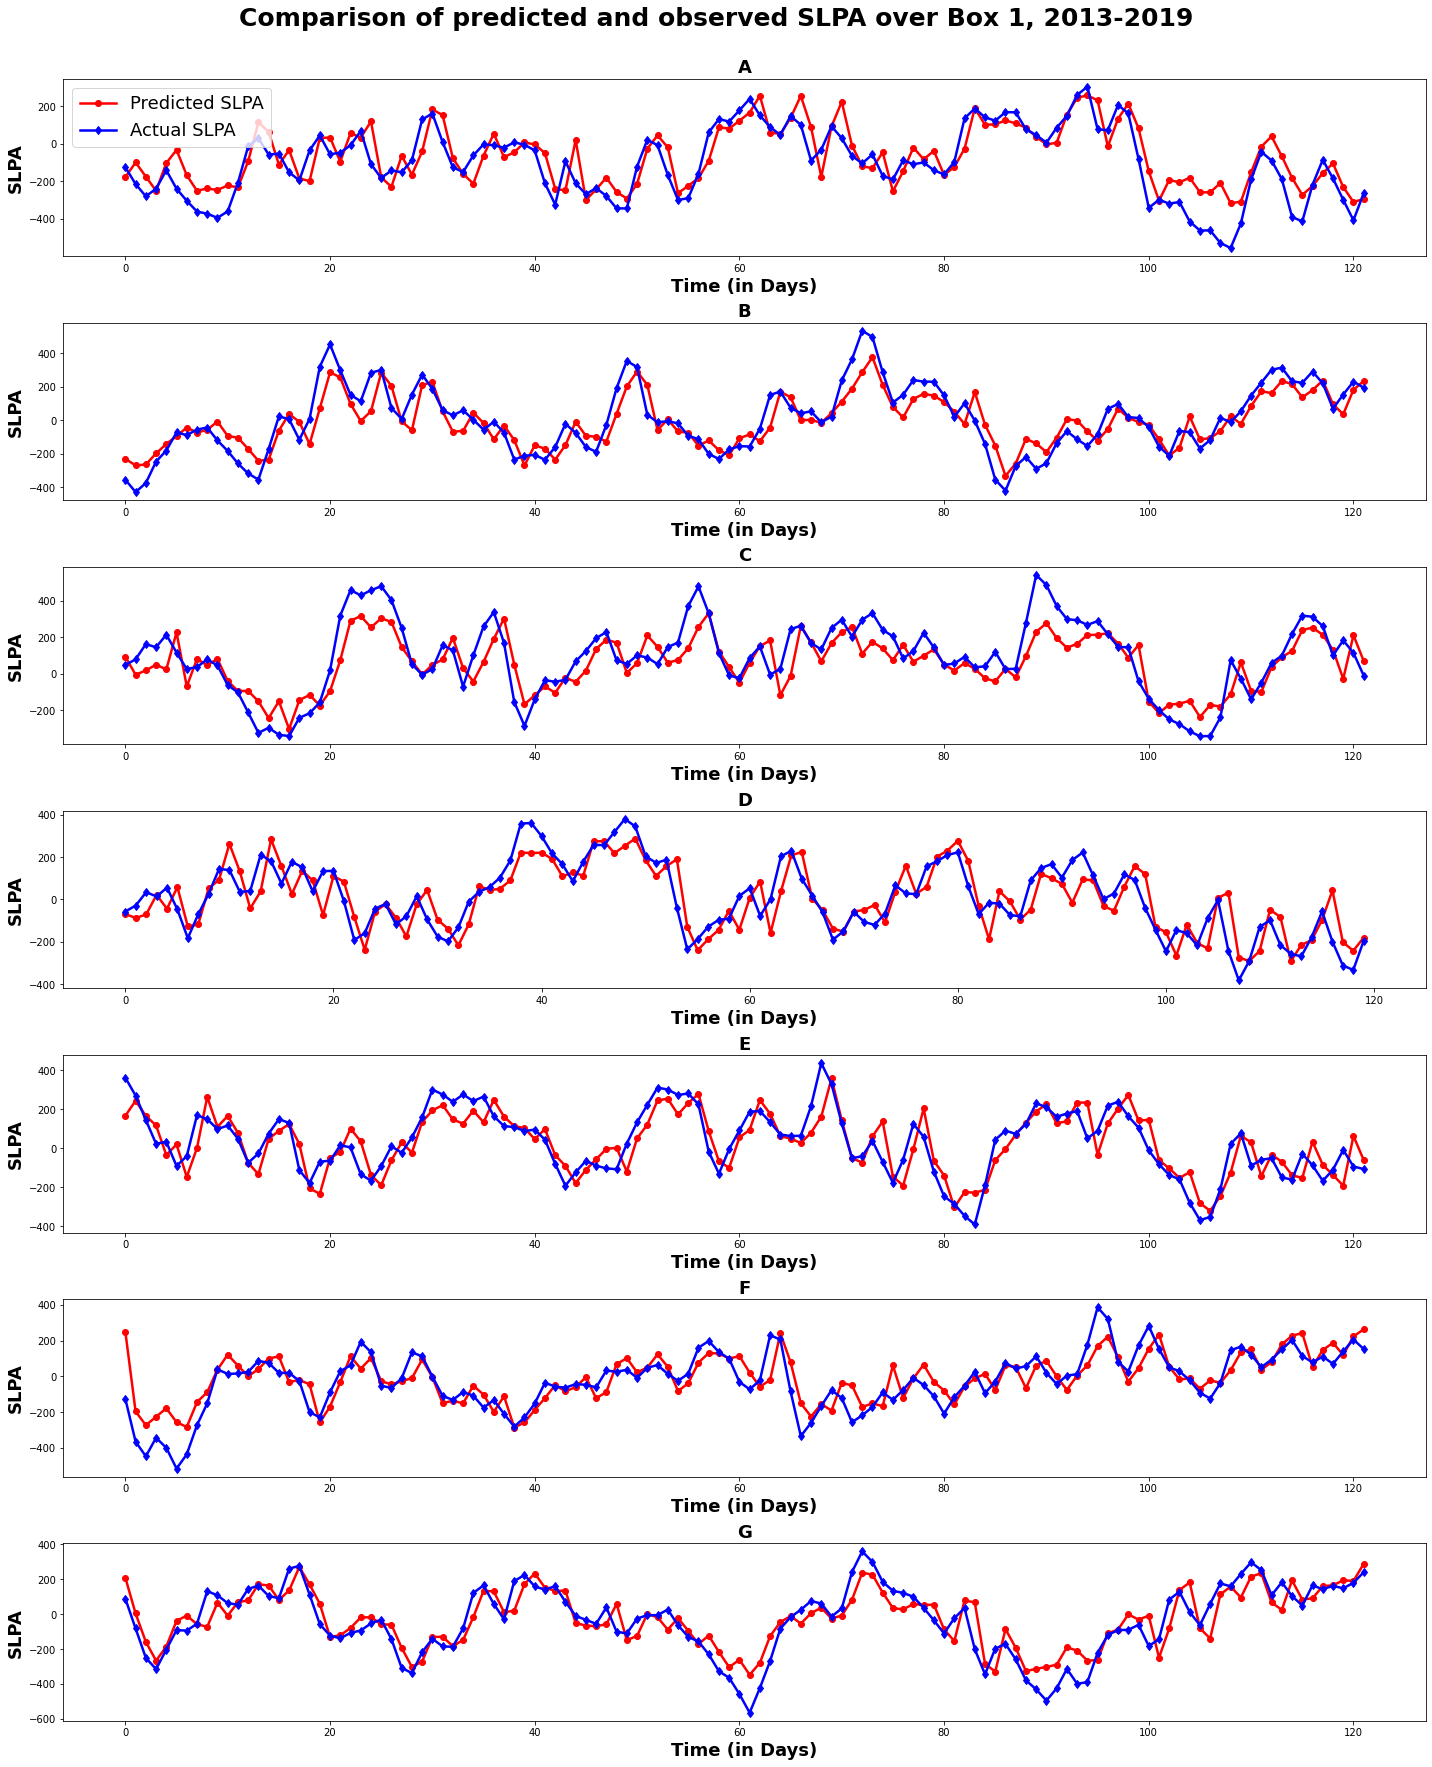

In [ ]:
from matplotlib.pyplot import figure
#figure(num=None, figsize=(30, 8), dpi=300, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(7, figsize=(20,25))
fig.suptitle('Comparison of predicted and observed SLPA over Box 1, 2013-2019', fontsize = '25', fontweight="bold")

axs[0].plot(predicted_slpa[888:1010], 'r-o', label='Predicted SLPA', linewidth=2.5)
axs[0].plot(y_test[888:1010], 'b-d', label='Actual SLPA', linewidth=2.5)
axs[0].legend(loc=2, fontsize='18')
axs[0].set_title('A', fontsize='18', fontweight="bold")
#axs[0].xlabel('Time',fontsize='12')

axs[1].plot(predicted_slpa[1253:1375], 'r-o', label='Predicted SLPA', linewidth=2.5)
axs[1].plot(y_test[1253:1375], 'b-d', label='Actual SLPA', linewidth=2.5)
#axs[1].legend(loc=2, fontsize='13')
axs[1].set_title('B', fontsize='18', fontweight="bold")

axs[2].plot(predicted_slpa[1618:1740], 'r-o', label='Predicted SLPA', linewidth=2.5)
axs[2].plot(y_test[1618:1740], 'b-d', label='Actual SLPA', linewidth=2.5)
#axs[2].legend(loc=2, fontsize='13')
axs[2].set_title('C', fontsize='18', fontweight="bold")

axs[3].plot(predicted_slpa[1986:2106], 'r-o', label='Predicted SLPA', linewidth=2.5)
axs[3].plot(y_test[1986:2106], 'b-d', label='Actual SLPA', linewidth=2.5)
#axs[3].legend(loc=2, fontsize='13')
axs[3].set_title('D', fontsize='18', fontweight="bold")

axs[4].plot(predicted_slpa[2349:2471], 'r-o', label='Predicted SLPA', linewidth=2.5)
axs[4].plot(y_test[2349:2471], 'b-d', label='Actual SLPA', linewidth=2.5)
#axs[4].legend(loc=2, fontsize='13')
axs[4].set_title('E', fontsize='18', fontweight="bold")

axs[5].plot(predicted_slpa[2714:2836], 'r-o', label='Predicted SLPA', linewidth=2.5)
axs[5].plot(y_test[2714:2836], 'b-d', label='Actual SLPA', linewidth=2.5)
#axs[5].legend(loc=2, fontsize='13')
axs[5].set_title('F', fontsize='18', fontweight="bold")

axs[6].plot(predicted_slpa[3080:3202], 'r-o', label='Predicted SLPA', linewidth=2.5)
axs[6].plot(y_test[3080:3202], 'b-d', label='Actual SLPA', linewidth=2.5)
#axs[6].legend(loc=2, fontsize='13')
axs[6].set_title('G', fontsize='18', fontweight="bold")

for ax in axs.flat:
    ax.set_xlabel('Time (in Days)', fontsize='18', fontweight="bold")
    ax.set_ylabel('SLPA', fontsize='18', fontweight="bold")
    

#plt.plot(predicted_slpa[888:1010], 'r', label='Predicted SLPA')
#plt.plot(y_test[888:1010], 'b', label='Actual SLPA')
#plt.xlabel('Time', fontsize='14')
#plt.ylabel('SLPA', fontsize='14')
#plt.title('Comparison of predicted and observed SLP Anomaly, 2013', fontsize='16')
#plt.legend(loc=1, fontsize='14')

fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.savefig("drive/My Drive/Box3_2013-2019_gap2.pdf", dpi=300)

In [ ]:
#Use this to save the data into a .nc file

import netCDF4
root_grp=netCDF4.Dataset("drive/My Drive/grid_data_box1_gap2.nc","w", format="NETCDF4")
root_grp.description = 'SLP Data'

# dimensions
root_grp.createDimension('time', None)
root_grp.createDimension('lat', 5)
root_grp.createDimension('lon', 5)

# variables
times = root_grp.createVariable('time', 'f8', ('time',))
latitudes = root_grp.createVariable('latitude', 'f4', ('lat',))
longitudes = root_grp.createVariable('longitude', 'f4', ('lon',))
temp = root_grp.createVariable('temp', 'f4', ('time', 'lat', 'lon',))

lats =  np.arange(20, 32.5, 2.5)
lons =  np.arange(70, 82.5, 2.5)
latitudes[:] = lats
longitudes[:] = lons
for i in range(888,3286):
    temp[i-888,:,:] = predicted_slpa[i]

root_grp.close()


In [ ]:
# not useful
'''read_file = 'drive/My Drive/grid_data.nc'
fh = Dataset(read_file, mode='r')
#print(fh.variables)
lons = fh.variables['longitude'][:]
lats = fh.variables['latitude'][:]
#length = fh.variables['time'][:]
#length_units = fh.variables['time'].units
slpa = fh.variables['temp'][:]
print(slpa.shape)'''

"read_file = 'drive/My Drive/grid_data.nc'\nfh = Dataset(read_file, mode='r')\n#print(fh.variables)\nlons = fh.variables['longitude'][:]\nlats = fh.variables['latitude'][:]\n#length = fh.variables['time'][:]\n#length_units = fh.variables['time'].units\nslpa = fh.variables['temp'][:]\nprint(slpa.shape)"